In [1]:
from torchvision.datasets import DatasetFolder
from torchvision.transforms import transforms as tt
from torch.utils.data import DataLoader
import torch
import os
import numpy as np
import timm_3d

c:\Users\Yina Gao\Documents\thesis-brain-tumour\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_path = "C:/Users/Yina Gao/Documents/thesis-brain-tumour/test_output/splits/train"
val_path = "C:/Users/Yina Gao/Documents/thesis-brain-tumour/test_output/splits/val"
test_path = "C:/Users/Yina Gao/Documents/thesis-brain-tumour/test_output/splits/test"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cpu


In [4]:
## define hyperparameters

## start with 16, then 8, 4, 2, 1 etc. (8 might be the best bet)
bs = 1

In [5]:
def pad_to_shape(volume, target_shape):
    """ Pads 3D numpy array (D,H,W) to target_shape with zeros. """
    pad_width = []
    for vol_dim, target_dim in zip(volume.shape, target_shape):
        delta = max(target_dim - vol_dim, 0)
        before = delta // 2
        after = delta - before
        pad_width.append((before, after))
    return np.pad(volume, pad_width, mode="constant", constant_values=0)

In [6]:
# 2. First pass: Determine maximum shape across train/val/test
def get_all_shapes(paths):
    shapes = []
    for p in paths:
        for root, _, files in os.walk(p):
            for f in files:
                if f.endswith(".npy"):
                    vol = np.load(os.path.join(root, f))  # (H, W, D)

                    # Convert to (D, H, W) BEFORE shape collection
                    vol = np.transpose(vol, (2, 0, 1))

                    shapes.append(vol.shape)
    return shapes

shapes = get_all_shapes([train_path, val_path, test_path])
target_shape = tuple(np.max(np.array(shapes), axis=0))


In [7]:
target_shape

(np.int64(124), np.int64(219), np.int64(191))

In [8]:
def custom_loader(path, pad:bool = True):
    vol = np.load(path)  # (H,W,D)
    vol = np.transpose(vol, (2, 0, 1)) # convert to (D, H, W)
    if pad:
        vol = pad_to_shape(vol, target_shape)
    vol = torch.tensor(vol, dtype=torch.float32)  # convert to tensor
    return vol

## Load Data + Set up model

In [9]:
import timm_3d
import torch.nn as nn

class TumourClassifier3D(nn.Module):
    def __init__(self, backbone_name='efficientnet_b1.ft_in1k', pretrained=True, num_classes=1):
        super().__init__()
        
        # Load backbone
        self.model = timm_3d.create_model(
            backbone_name,
            pretrained=pretrained,
            in_chans=1,     # single-channel (D,H,W)
            num_classes=0   # remove classification head
        )
        
        # Get output feature dimension
        if hasattr(self.model, "num_features"):
            feat_dim = self.model.num_features
        else:
            feat_dim = self.model.num_features
    
        # Add binary classifier head
        self.classifier = nn.Linear(feat_dim, num_classes)
    
    def forward(self, x):
        x = self.model(x)     # (B, feat_dim)
        x = self.classifier(x)
        return x

In [10]:
class AddChannel:
    def __call__(self, x):
        return x.unsqueeze(0)   # (1, D, H, W)

In [11]:
train_transforms = AddChannel()
test_transforms  = AddChannel()

In [12]:
# Load dataset
train_dataset = DatasetFolder(train_path, loader=custom_loader, transform=train_transforms, extensions=[".npy"])
# Access class labels
print(train_dataset.classes)
# Create a DataLoader
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

val_dataset = DatasetFolder(val_path, loader=custom_loader, transform=test_transforms, extensions=[".npy"])
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
test_dataset = DatasetFolder(test_path, loader=custom_loader, transform=test_transforms, extensions=[".npy"])
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

['medulloblastoma', 'plgg']


### visualize slices (sanity check)

torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) medulloblastoma
torch.Size([1, 124, 219, 191]) plgg
torch.Size([1, 124, 219, 191]) plgg


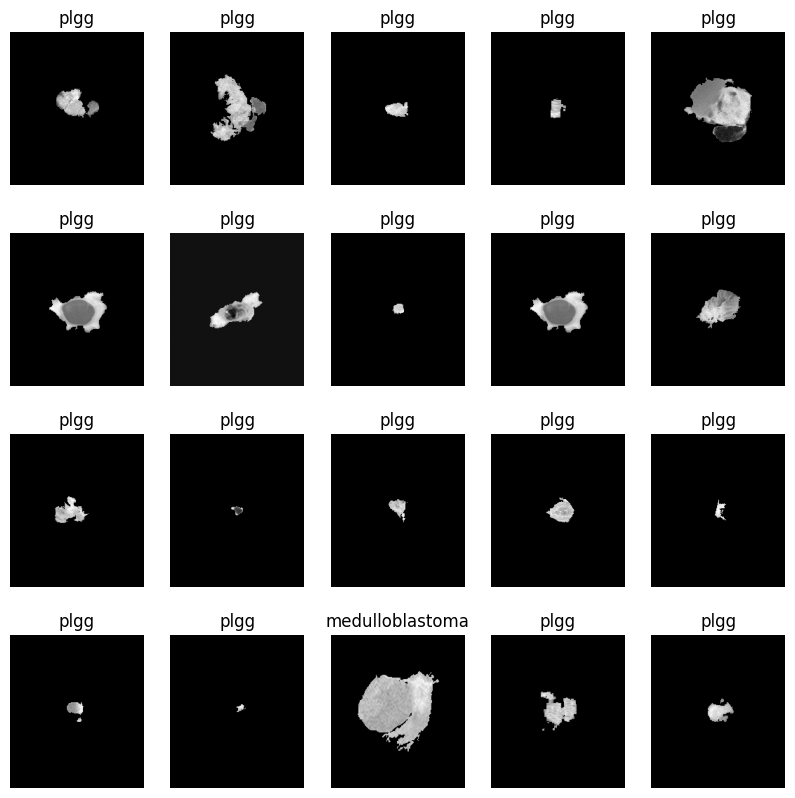

In [13]:
import matplotlib.pyplot as plt
from random import randint

# labels_map = {
#     0: "dipg",
#     1: "medulloblastoma",
#     2: "plgg"
# }

labels_map = {
    0: "medulloblastoma",
    1: "plgg"
}


# now in (1, D, W, H order)
figure = plt.figure(figsize=(10, 10))
cols, rows = 5, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    tensor, label = train_dataset[sample_idx]
    print(tensor.shape, labels_map[label])
    c, d, h, w = tensor.shape
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(tensor[:,d//2,:,:].squeeze(), cmap="gray")
plt.show()

# For timm_3d the input shape must be (B, C, D, H, W).

In [14]:
# from tqdm import tqdm
# import torch.nn as nn
# import torch.optim as optim

# class Trainer:
#     def __init__(self, model, train_loader, val_loader, device=device):
#         self.device = device
#         self.model = model.to(self.device)
#         self.train_loader = train_loader
#         self.val_loader = val_loader

#         self.criterion = nn.BCEWithLogitsLoss()
#         self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
    
#     def train_one_epoch(self):
#         self.model.train()
#         total_loss = 0
        
#         for x, y in tqdm(self.train_loader):
#             x = x.to(self.device)
#             y = y.float().to(self.device)  # 0/1 labels

#             preds = self.model(x).squeeze(-1)
#             loss = self.criterion(preds, y)

#             self.optimizer.zero_grad()
#             loss.backward()
#             self.optimizer.step()

#             total_loss += loss.item()
        
#         return total_loss / len(self.train_loader)
    
#     def validate(self):
#         self.model.eval()
#         total_loss = 0
        
#         with torch.no_grad():
#             for x, y in self.val_loader:
#                 x = x.to(self.device)
#                 y = y.float().to(self.device)

#                 preds = self.model(x).squeeze(-1)
#                 loss = self.criterion(preds, y)
#                 total_loss += loss.item()
        
#         return total_loss / len(self.val_loader)
    
#     def fit(self, epochs=10):
#         for e in range(1, epochs + 1):
#             train_loss = self.train_one_epoch()
#             val_loss = self.validate()
#             print(f"Epoch {e}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_fscore_support
)
import numpy as np
import os


class Trainer:
    def __init__(
        self, 
        model, 
        train_loader, 
        val_loader, 
        test_loader=None, 
        device="cuda",
        save_dir="results",
        patience=10
    ):
        self.device = device
        self.model = model.to(self.device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)

        # tracking
        self.train_losses = []
        self.val_losses = []

        # early stopping
        self.best_val_loss = float("inf")
        self.patience = patience
        self.counter = 0

        # saving
        self.save_dir = save_dir
        os.makedirs(save_dir, exist_ok=True)
    

    def train_one_epoch(self):
        self.model.train()
        total_loss = 0
        
        for x, y in tqdm(self.train_loader):
            x = x.to(self.device)
            y = y.float().to(self.device)

            preds = self.model(x).squeeze(-1)
            loss = self.criterion(preds, y)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()
        
        return total_loss / len(self.train_loader)
    
    def validate(self):
        self.model.eval()
        total_loss = 0
        
        with torch.no_grad():
            for x, y in self.val_loader:
                x = x.to(self.device)
                y = y.float().to(self.device)

                preds = self.model(x).squeeze(-1)
                loss = self.criterion(preds, y)
                total_loss += loss.item()
        
        return total_loss / len(self.val_loader)

    def _collect_outputs(self, loader):
        self.model.eval()
        preds_list = []
        probs_list = []
        labels_list = []

        with torch.no_grad():
            for x, y in loader:
                x = x.to(self.device)
                y = y.float().to(self.device)

                logits = self.model(x).squeeze(-1)
                probs = torch.sigmoid(logits)

                preds_list.append((probs > 0.5).float().cpu().numpy())
                probs_list.append(probs.cpu().numpy())
                labels_list.append(y.cpu().numpy())

        preds = np.concatenate(preds_list)
        probs = np.concatenate(probs_list)
        labels = np.concatenate(labels_list)

        return preds, probs, labels

    def plot_loss_curve(self):
        plt.figure()
        plt.plot(self.train_losses, label="Train Loss")
        plt.plot(self.val_losses, label="Val Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.title("Training vs Validation Loss")
        plt.savefig(os.path.join(self.save_dir, "loss_curve.png"))
        plt.close()

    def plot_auc_curve(self, loader, split="val"):
        preds, probs, labels = self._collect_outputs(loader)
        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = auc(fpr, tpr)

        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0,1],[0,1],"--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({split})")
        plt.legend()
        plt.savefig(os.path.join(self.save_dir, f"roc_curve_{split}.png"))
        plt.close()

    def compute_confusion_metrics(self, loader, split="test"):
        preds, probs, labels = self._collect_outputs(loader)

        cm = confusion_matrix(labels, preds)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.title(f"Confusion Matrix ({split})")
        plt.savefig(os.path.join(self.save_dir, f"confusion_matrix_{split}.png"))
        plt.close()

        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average="binary"
        )

        return precision, recall, f1

    def _check_early_stopping(self, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.counter = 0
            # save best weights
            torch.save(self.model.state_dict(), os.path.join(self.save_dir, "best_model.pt"))
        else:
            self.counter += 1
            print(f"Early stopping patience: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                print("Early stopping triggered.")
                return True
        return False

    def fit(self, epochs=10):
        for e in range(1, epochs + 1):
            train_loss = self.train_one_epoch()
            val_loss = self.validate()

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

            print(f"Epoch {e}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            if self._check_early_stopping(val_loss):
                break
        
        self.plot_loss_curve()
        self.plot_auc_curve(self.val_loader, split="val")

        return

    def test(self):
        if self.test_loader is None:
            raise ValueError("No test_loader was provided.")

        # load best model
        self.model.load_state_dict(torch.load(os.path.join(self.save_dir, "best_model.pt")))

        # AUC
        self.plot_auc_curve(self.test_loader, split="test")

        # Confusion + precision/recall/F1
        precision, recall, f1 = self.compute_confusion_metrics(self.test_loader)

        print("\nTest Metrics:")
        print(f"Precision: {precision:.4f}")
        print(f"Recall:    {recall:.4f}")
        print(f"F1-score:  {f1:.4f}")

        return precision, recall, f1


In [16]:
# def run_experiment(backbone_name, train_loader, val_loader):
#     print(f"\nRunning experiment with {backbone_name} on {device}...\n")
    
#     model = TumourClassifier3D(backbone_name=backbone_name, pretrained=True)
#     trainer = Trainer(model, train_loader, val_loader, device=device)
#     trainer.fit(epochs=1)
    
#     return model

def run_experiment(backbone_name, train_loader, val_loader, test_loader, max_epochs):
    print(f"\nRunning experiment with {backbone_name} on {device}...\n")
    
    model = TumourClassifier3D(backbone_name=backbone_name, pretrained=True)
    
    trainer = Trainer(
        model,
        train_loader=train_loader,
        val_loader=val_loader,
        test_loader=test_loader,
        device=device,
        save_dir=f"results_{backbone_name}",
        patience=5
    )

    trainer.fit(epochs=max_epochs)
    trainer.test()

    return model

In [19]:
backbones = [
    "resnet18.a1_in1k",
    "resnext50_32x4d.fb_swsl_ig1b_ft_in1k",
    "tf_efficientnet_b2.in1k",
    "convnext_tiny",
    "densenet121"
]

models = {}

for b in backbones[:1]:
    models[b] = run_experiment(b, train_loader, val_loader, test_loader=test_loader, max_epochs=1)


Running experiment with resnet18.a1_in1k on cpu...



c:\Users\Yina Gao\Documents\thesis-brain-tumour\.venv\Lib\site-packages\huggingface_hub\file_download.py:121: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Yina Gao\.cache\huggingface\hub\models--timm--resnet18.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


Convert layer weights: conv1.weight. Shape: torch.Size([64, 1, 7, 7]) -> torch.Size([64, 1, 7, 7, 7])
Convert layer weights: layer1.0.conv1.weight. Shape: torch.Size([64, 64, 3, 3]) -> torch.Size([64, 64, 3, 3, 3])
Convert layer weights: layer1.0.conv2.weight. Shape: torch.Size([64, 64, 3, 3]) -> torch.Size([64, 64, 3, 3, 3])
Convert layer weights: layer1.1.conv1.weight. Shape: torch.Size([64, 64, 3, 3]) -> torch.Size([64, 64, 3, 3, 3])
Convert layer weights: layer1.1.conv2.weight. Shape: torch.Size([64, 64, 3, 3]) -> torch.Size([64, 64, 3, 3, 3])
Convert layer weights: layer2.0.conv1.weight. Shape: torch.Size([128, 64, 3, 3]) -> torch.Size([128, 64, 3, 3, 3])
Convert layer weights: layer2.0.conv2.weight. Shape: torch.Size([128, 128, 3, 3]) -> torch.Size([128, 128, 3, 3, 3])
Convert layer weights: layer2.0.downsample.0.weight. Shape: torch.Size([128, 64, 1, 1]) -> torch.Size([128, 64, 1, 1, 1])
Convert layer weights: layer2.1.conv1.weight. Shape: torch.Size([128, 128, 3, 3]) -> torch.S

100%|██████████| 400/400 [10:19<00:00,  1.55s/it]


Epoch 1/1 | Train Loss: 0.1028 | Val Loss: 0.2794

Test Metrics:
Precision: 0.8256
Recall:    1.0000
F1-score:  0.9045


## artifacts

- AUC plots
- confusion matrix
- precision/recall/1
- training/val loss curves 
- early stopping + save weights
- save smaller files to local (hpc local > )

- completely frozen backbones 
- a bit of hyperparameter tuning 
- if I have time, can try some of the 1 layer unfrozen 
- can just queue a ton of jobs and see which ones finish --> separate jobs for different model configurations 

- pick like 5 backbones (try like 2 usual ones, 3 newer ones)

remember: DIPG issue --> pure binary classification 